In [2]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [3]:
ngram_dct = pk.load(open("ngram_dct.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))


In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

## unigram

In [ ]:
train_features = ngram_dct['train_1']
val_features = ngram_dct['val_1']
test_features = ngram_dct['test_1']

In [21]:
#adam
max_vocab_size_list = [10000, 20000, 30000, 50000, 100000]
val_acc_adam = []
val_curve_adam_unigram = []
for max_vocab_size in max_vocab_size_list:
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)


    val_curve_adam_unigram.append(val_acc_list)
    val_acc_adam.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [24:51<00:00, 149.19s/it]


finish vocab size 100000, val_acc: 85.64


Text(0.5,1,'spacy tokenization, unigram, adam optimization (lr=0.01), embedding_dim = 100')

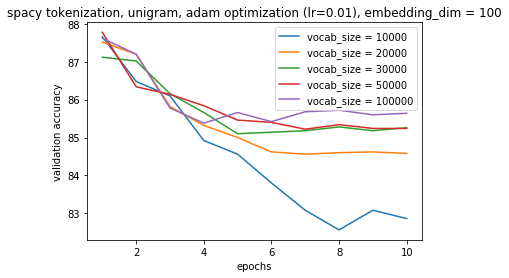

In [26]:
for i in range(len(val_curve_adam_unigram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_unigram[i], label = 'vocab_size = %s' %max_vocab_size_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, unigram, adam optimization (lr=0.01), embedding_dim = 100')

In [24]:
#sgd
max_vocab_size_list = [10000, 20000, 30000, 50000, 100000]
val_acc_sgd = []
val_curve_sgd_unigram = []
for max_vocab_size in max_vocab_size_list:
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)

    val_curve_sgd_unigram.append(val_acc_list)
    val_acc_sgd.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [20:49<00:00, 124.95s/it]


finish vocab size 10000, val_acc: 68.2


100%|██████████| 10/10 [24:27<00:00, 146.75s/it]


finish vocab size 20000, val_acc: 68.26


100%|██████████| 10/10 [26:26<00:00, 158.64s/it]


finish vocab size 30000, val_acc: 67.38


100%|██████████| 10/10 [26:54<00:00, 161.45s/it]


finish vocab size 50000, val_acc: 68.0


100%|██████████| 10/10 [27:38<00:00, 165.82s/it]


finish vocab size 100000, val_acc: 68.3


Text(0.5,1,'spacy tokenization, unigram, sgd optimization (lr=0.01), embedding_dim = 100')

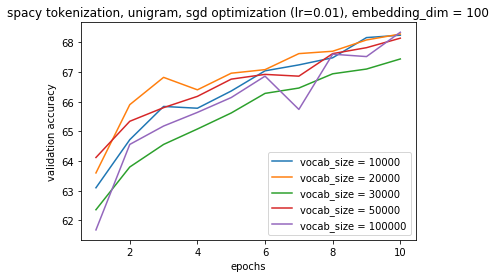

In [27]:
for i in range(len(val_curve_sgd_unigram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_sgd_unigram[i], label = 'vocab_size = %s' %max_vocab_size_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, unigram, sgd optimization (lr=0.01), embedding_dim = 100')

## bigram

In [38]:
train_features = ngram_dct['train_2']
val_features = ngram_dct['val_2']
test_features = ngram_dct['test_2']

In [39]:
#adam
max_vocab_size_list = [10000, 20000, 30000, 50000, 100000]
val_acc_adam_bigram = []
val_curve_adam_bigram = []
for max_vocab_size in max_vocab_size_list:
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)

    val_curve_adam_bigram.append(val_acc_list)
    val_acc_adam_bigram.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [20:18<00:00, 121.84s/it]


finish vocab size 10000, val_acc: 79.7


100%|██████████| 10/10 [22:18<00:00, 133.86s/it]


finish vocab size 20000, val_acc: 83.02


100%|██████████| 10/10 [23:07<00:00, 138.73s/it]


finish vocab size 30000, val_acc: 84.02


100%|██████████| 10/10 [25:10<00:00, 151.01s/it]


finish vocab size 50000, val_acc: 85.1


100%|██████████| 10/10 [1:17:37<00:00, 465.77s/it]


finish vocab size 100000, val_acc: 86.3


Text(0.5,1,'spacy tokenization, bigram, adam optimization (lr=0.01), embedding_dim = 100')

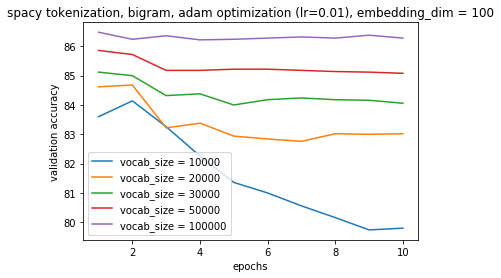

In [41]:
for i in range(len(val_curve_adam_bigram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_bigram[i], label = 'vocab_size = %s' %max_vocab_size_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, bigram, adam optimization (lr=0.01), embedding_dim = 100')

## trigram

In [42]:
train_features = ngram_dct['train_3']
val_features = ngram_dct['val_3']
test_features = ngram_dct['test_3']

In [43]:
val_acc_adam_trigram = []
val_curve_adam_trigram = []
for max_vocab_size in max_vocab_size_list:
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)

    val_curve_adam_trigram.append(val_acc_list)
    val_acc_adam_trigram.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [21:06<00:00, 126.67s/it]


finish vocab size 10000, val_acc: 74.64


100%|██████████| 10/10 [58:08<00:00, 348.83s/it]


finish vocab size 20000, val_acc: 77.86


100%|██████████| 10/10 [21:43<00:00, 130.38s/it]


finish vocab size 30000, val_acc: 79.6


100%|██████████| 10/10 [22:26<00:00, 134.63s/it]


finish vocab size 50000, val_acc: 80.9


100%|██████████| 10/10 [24:39<00:00, 147.93s/it]


finish vocab size 100000, val_acc: 82.3


Text(0.5,1,'spacy tokenization, trigram, adam optimization (lr=0.01), embedding_dim = 100')

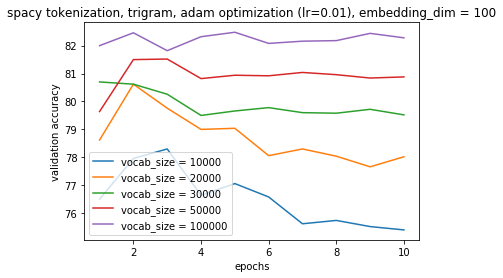

In [44]:
for i in range(len(val_curve_adam_trigram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_trigram[i], label = 'vocab_size = %s' %max_vocab_size_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, trigram, adam optimization (lr=0.01), embedding_dim = 100')

## 4gram

In [45]:
train_features = ngram_dct['train_4']
val_features = ngram_dct['val_4']
test_features = ngram_dct['test_4']

In [46]:
val_acc_adam_4gram = []
val_curve_adam_4gram = []
for max_vocab_size in max_vocab_size_list:
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)

    val_curve_adam_4gram.append(val_acc_list)
    val_acc_adam_4gram.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [36:52<00:00, 221.28s/it]


finish vocab size 10000, val_acc: 70.02


100%|██████████| 10/10 [22:07<00:00, 132.76s/it]


finish vocab size 20000, val_acc: 71.98


100%|██████████| 10/10 [26:35<00:00, 159.57s/it]


finish vocab size 30000, val_acc: 73.02


100%|██████████| 10/10 [33:18<00:00, 199.89s/it]


finish vocab size 50000, val_acc: 74.16


100%|██████████| 10/10 [28:11<00:00, 169.16s/it]


finish vocab size 100000, val_acc: 75.62


Text(0.5,1,'spacy tokenization, 4gram, adam optimization (lr=0.01), embedding_dim = 100')

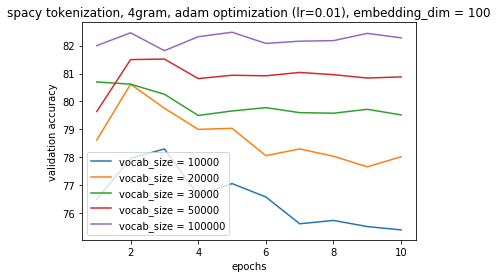

In [47]:
for i in range(len(val_curve_adam_4gram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_trigram[i], label = 'vocab_size = %s' %max_vocab_size_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, 4gram, adam optimization (lr=0.01), embedding_dim = 100')

In [50]:
C = pd.Index(["10k", "20k", "30k", "50k", "100k"], name="vocab size")
I = pd.Index(["1-gram", "2-gram", "3-gram", "4-gram"], name="ngram")
df = pd.DataFrame(data=np.random.rand(4,5), index=I, columns=C)

df.iloc[0] = val_acc_adam
df.iloc[1] = val_acc_adam_bigram
df.iloc[2] = val_acc_adam_trigram
df.iloc[3] = val_acc_adam_4gram

df

vocab size,10k,20k,30k,50k,100k
ngram,,,,,
1-gram,82.66,84.56,85.28,85.24,85.64
2-gram,79.70,83.02,84.02,85.10,86.30
3-gram,74.64,77.86,79.60,80.90,82.30
4-gram,70.02,71.98,73.02,74.16,75.62
